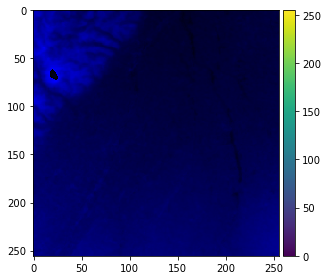

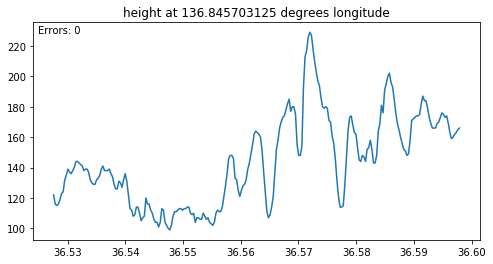

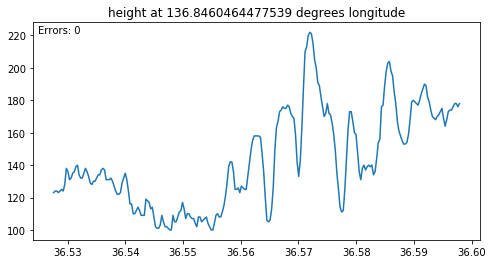

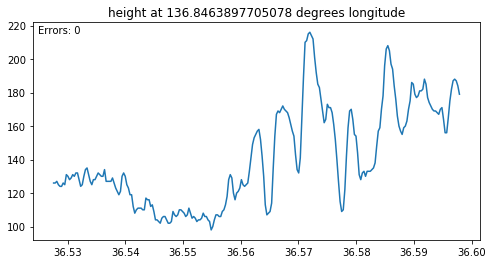

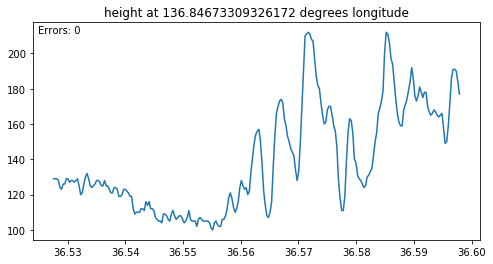

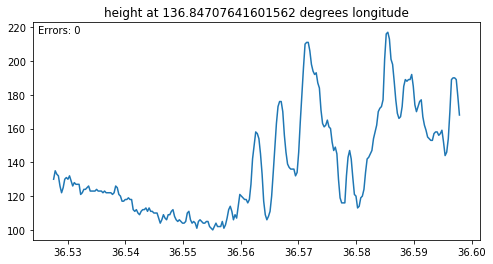

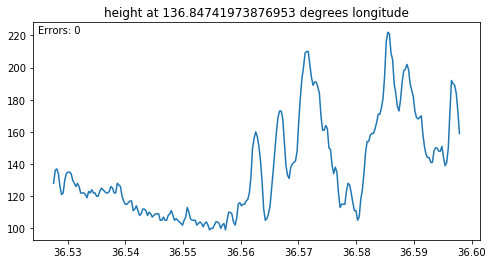

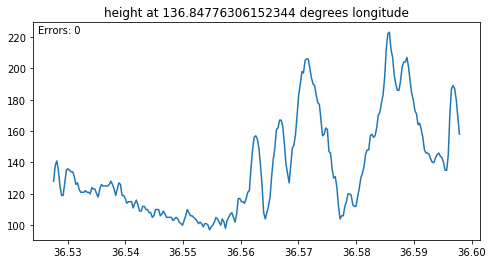

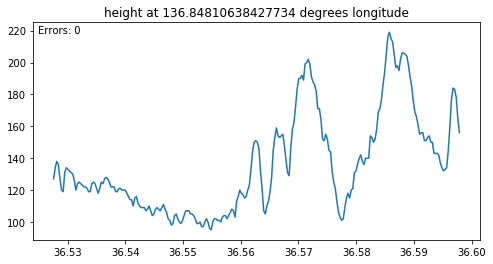

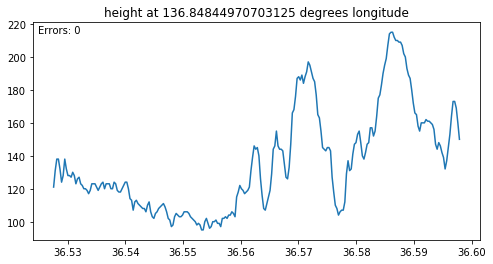

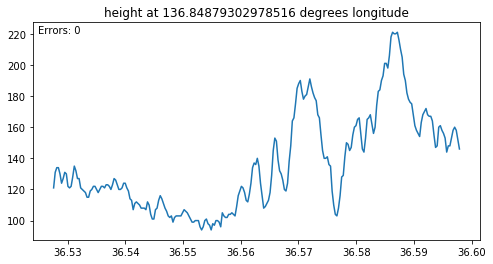

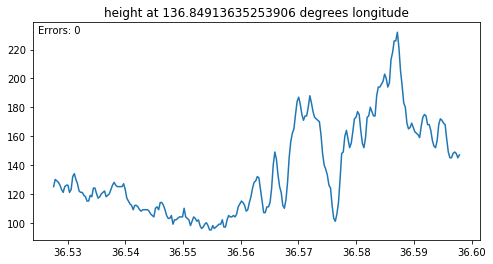

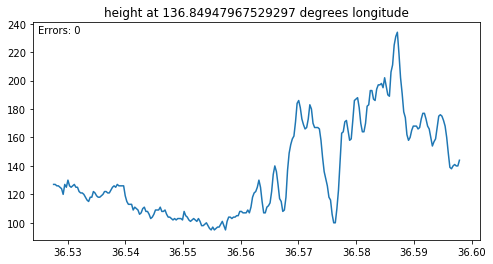

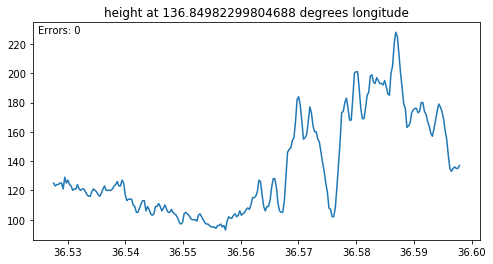

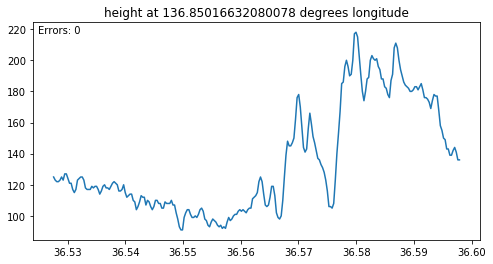

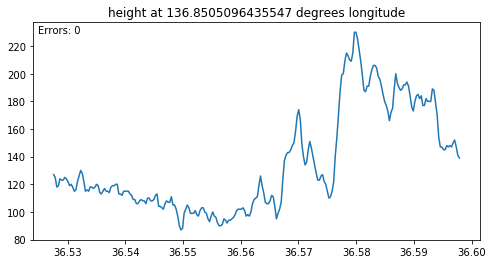

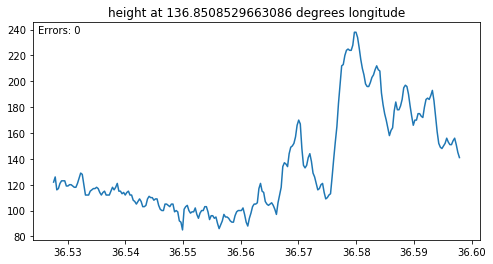

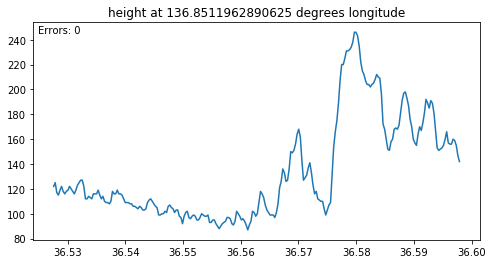

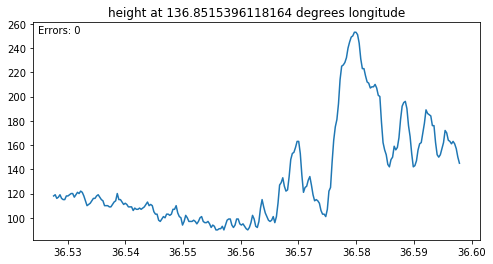

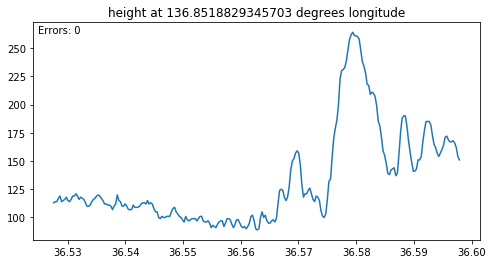

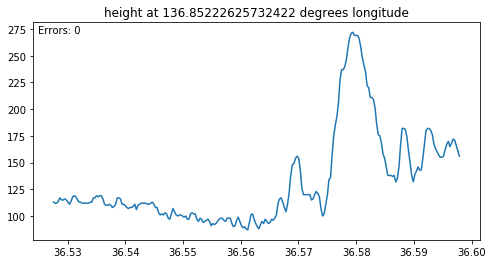

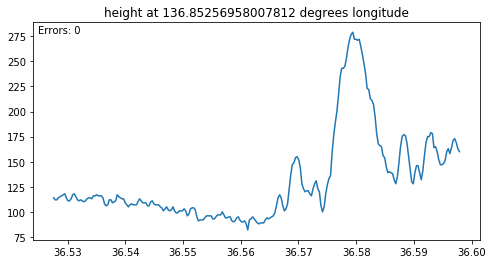

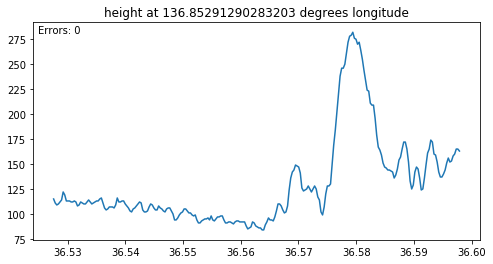

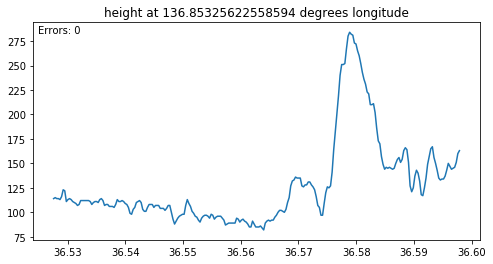

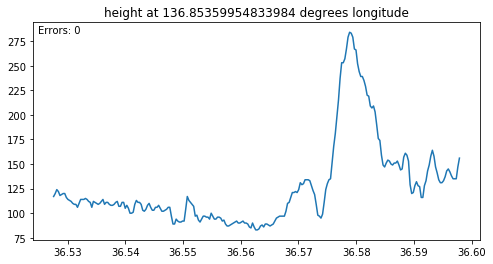

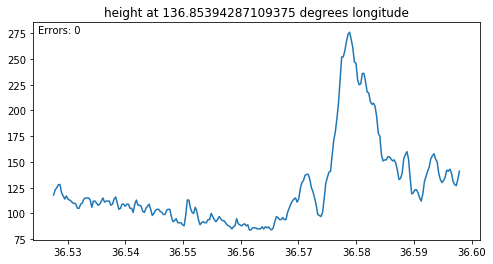

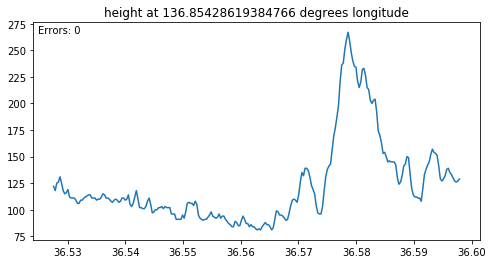

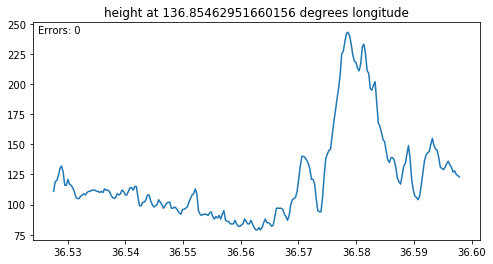

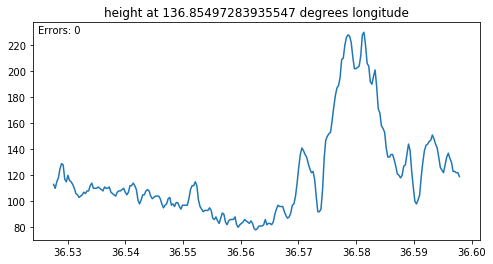

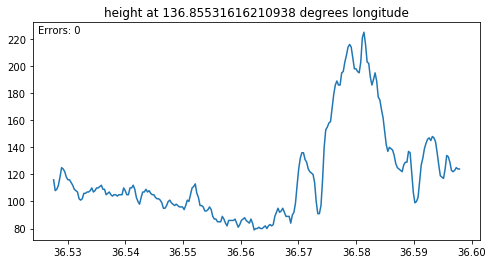

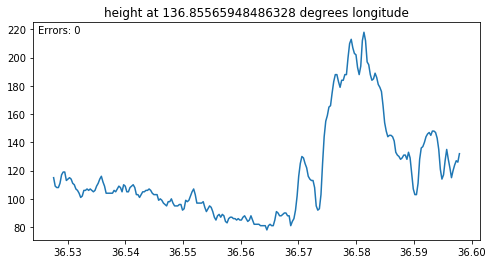

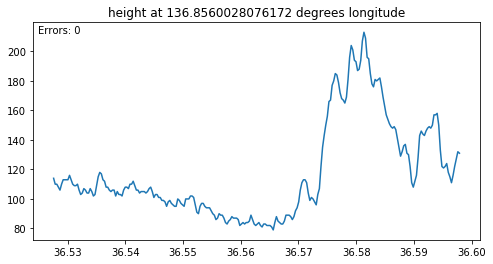

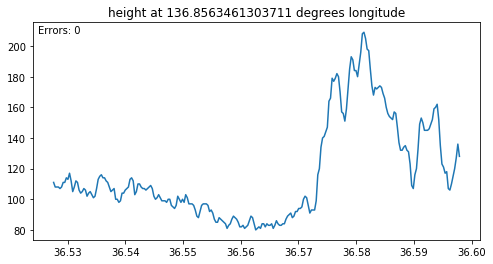

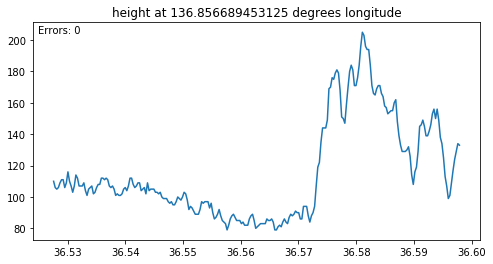

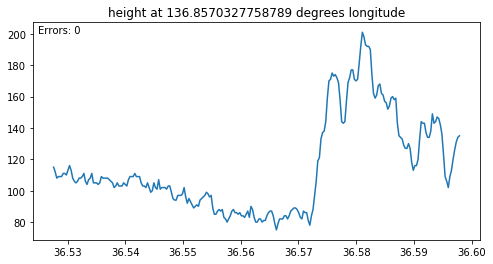

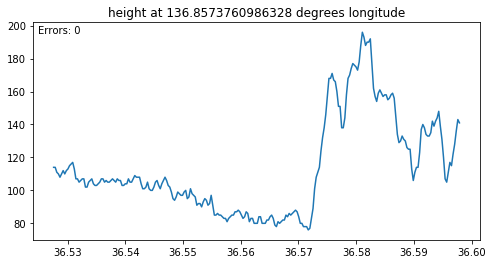

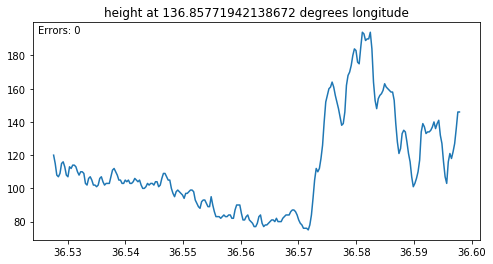

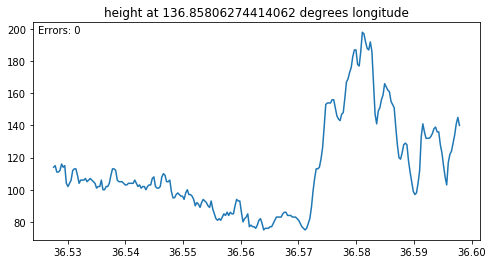

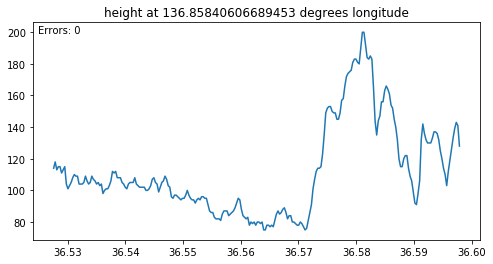

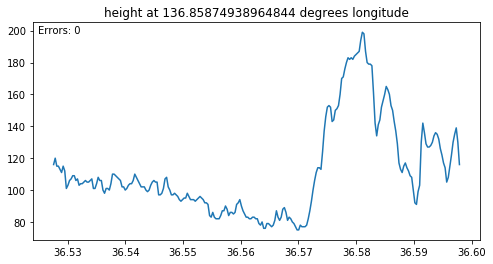

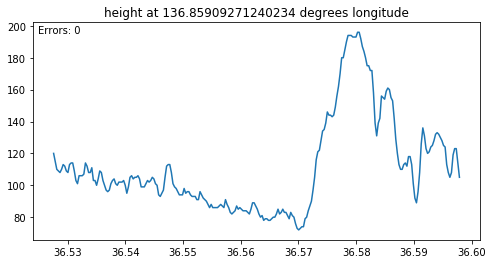

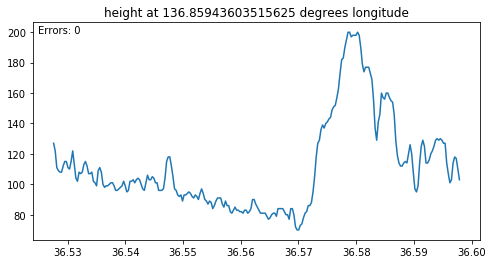

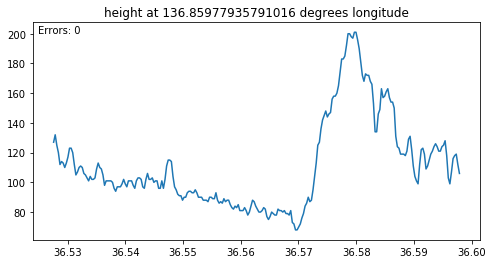

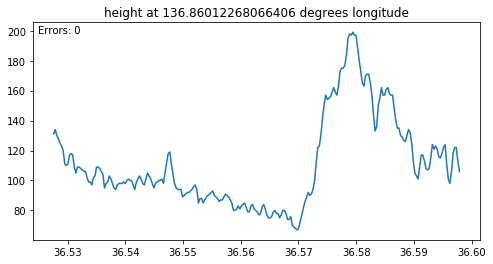

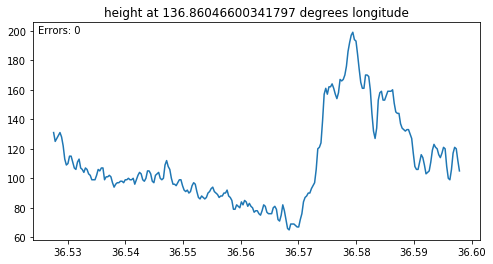

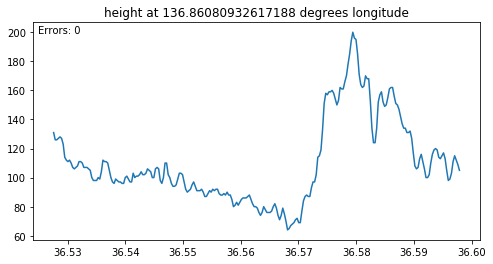

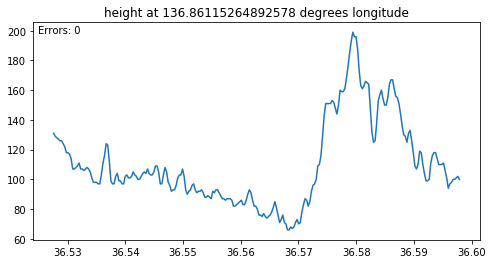

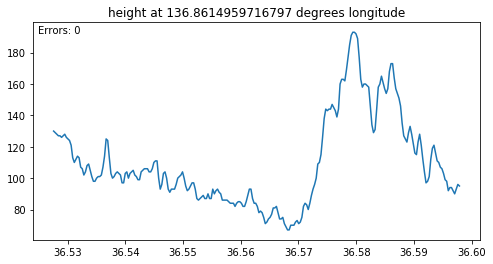

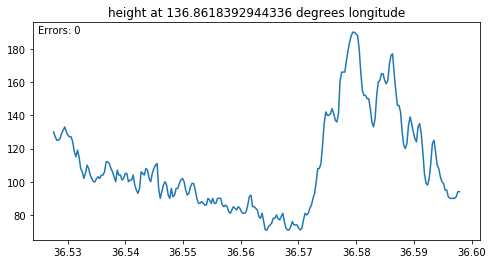

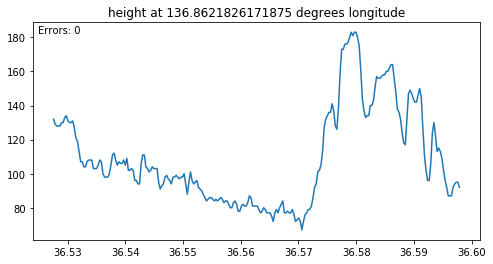

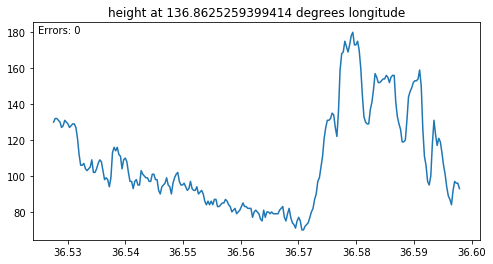

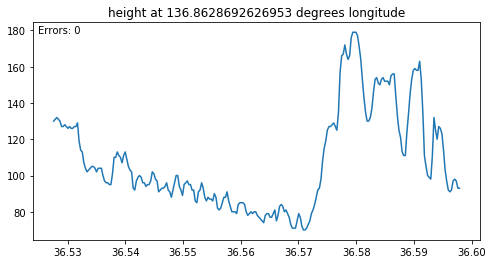

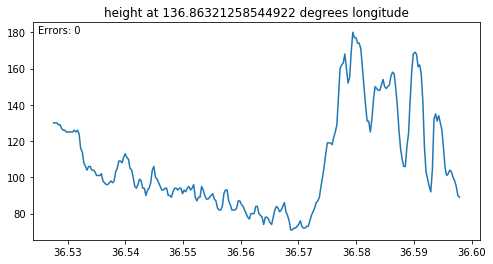

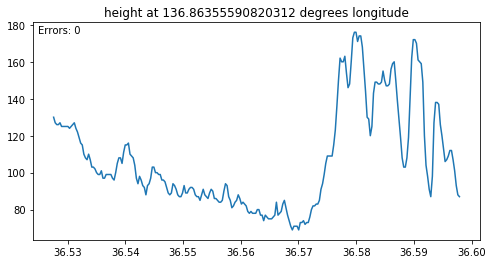

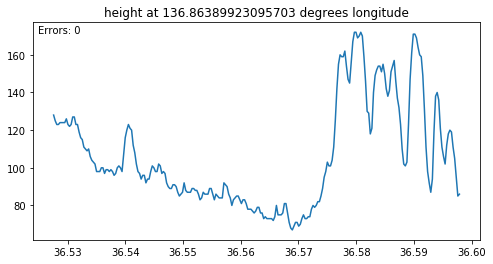

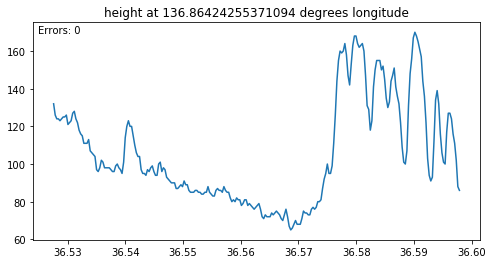

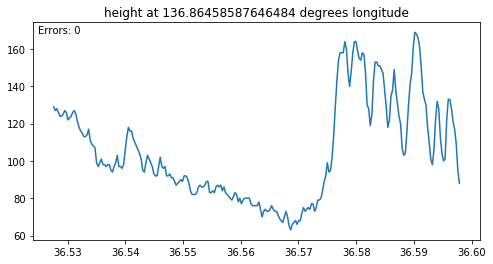

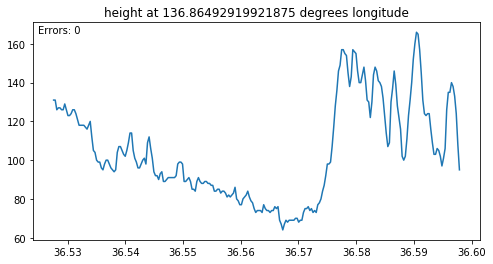

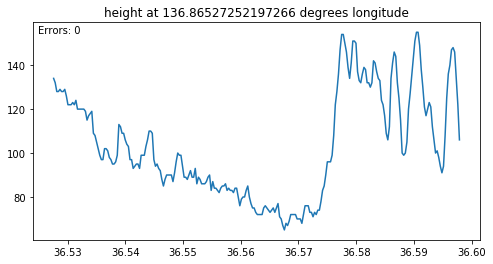

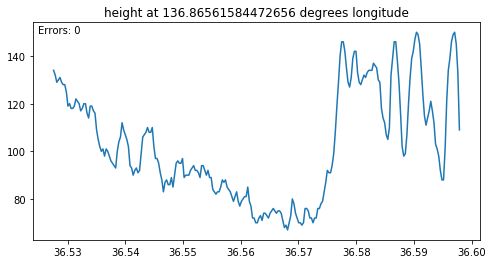

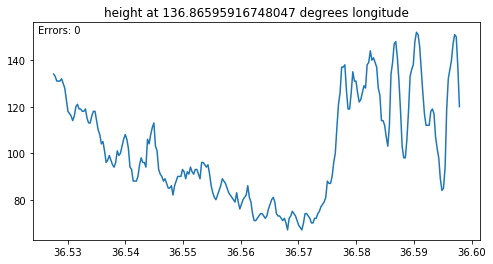

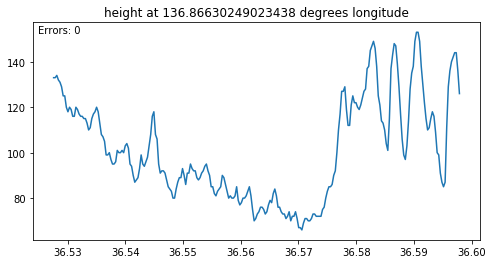

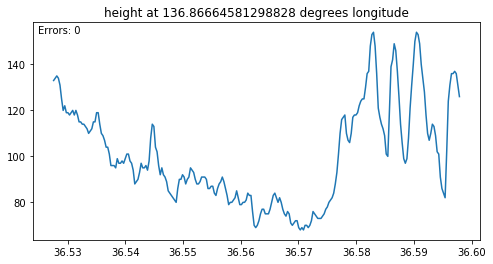

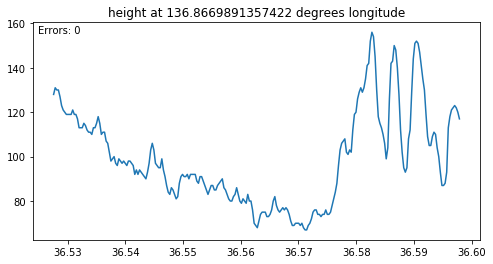

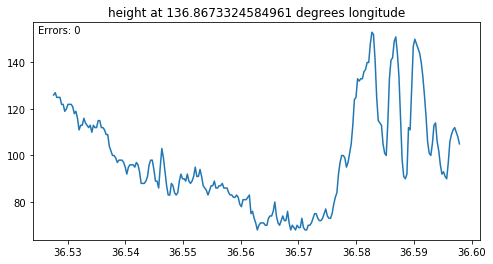

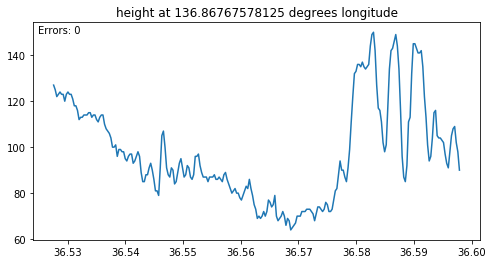

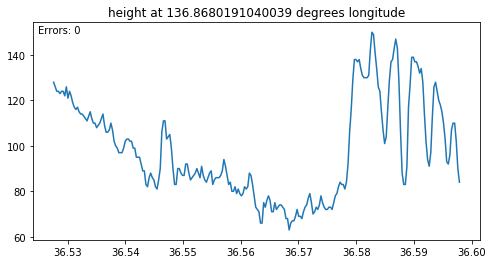

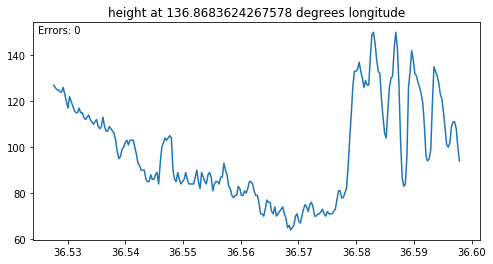

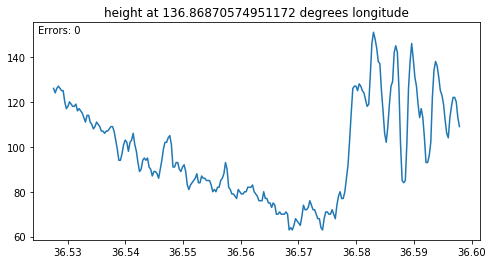

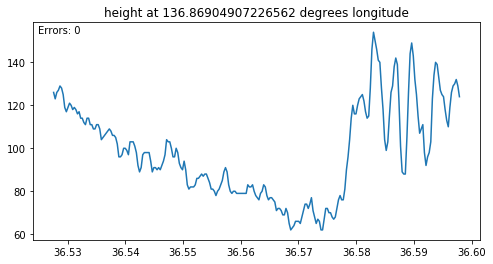

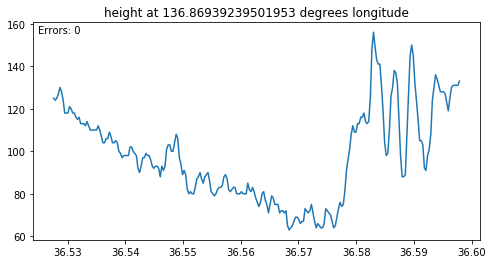

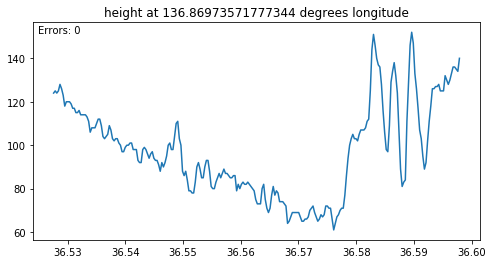

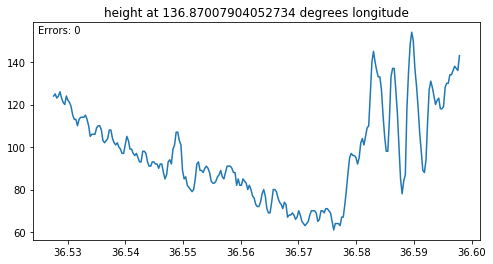

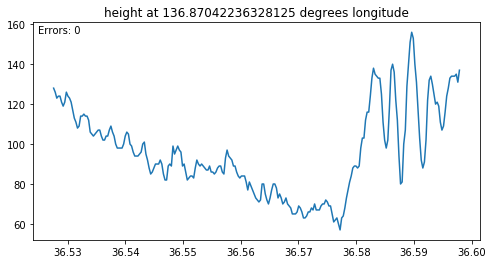

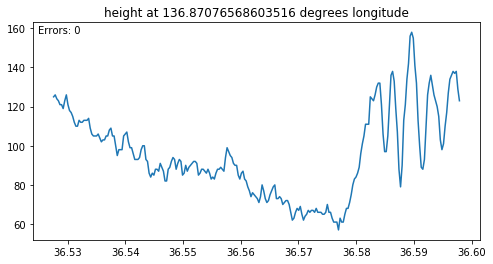

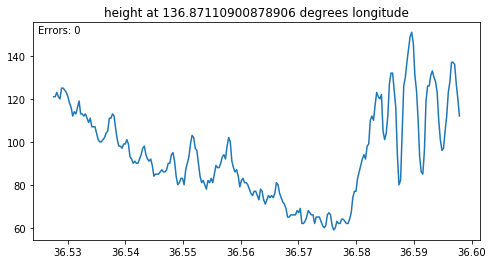

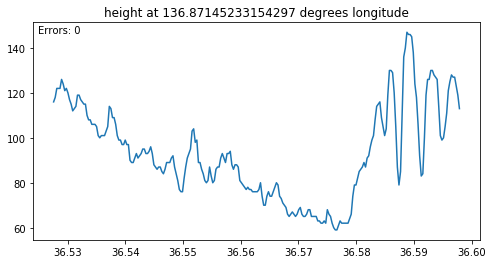

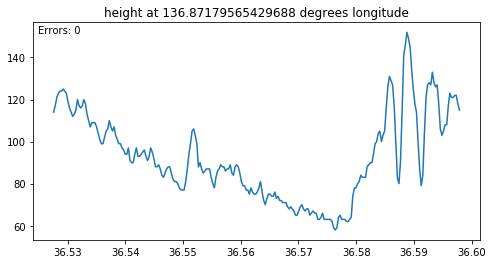

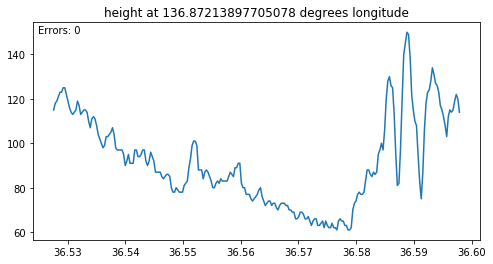

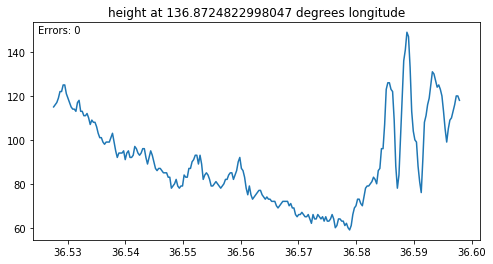

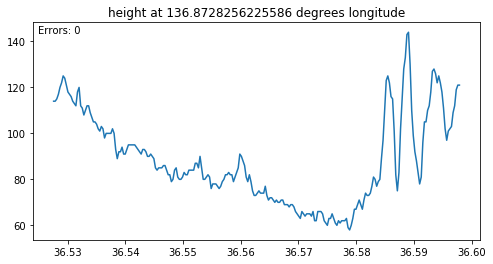

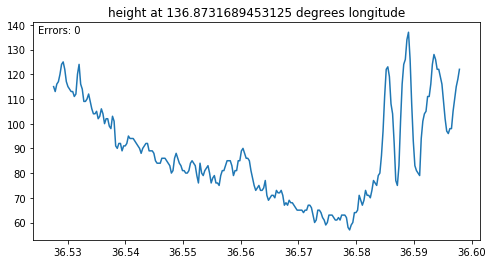

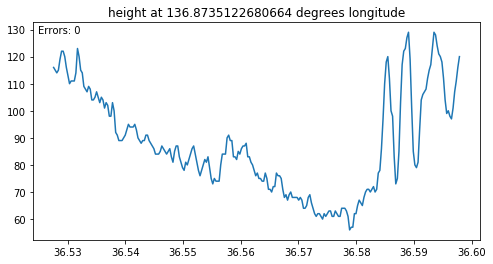

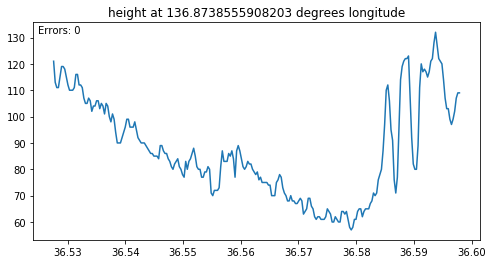

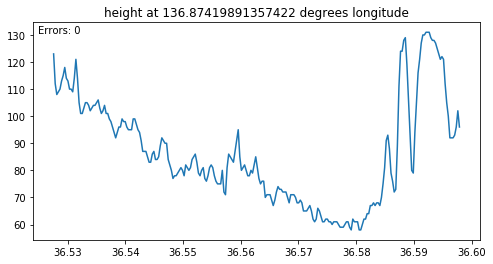

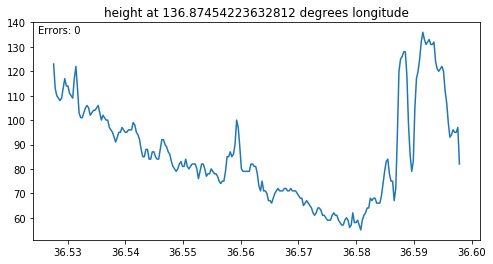

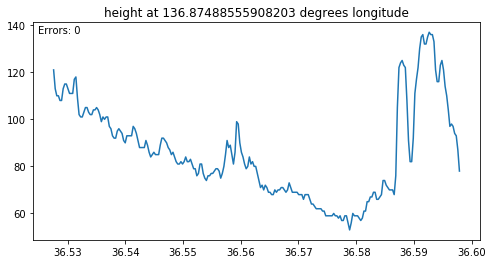

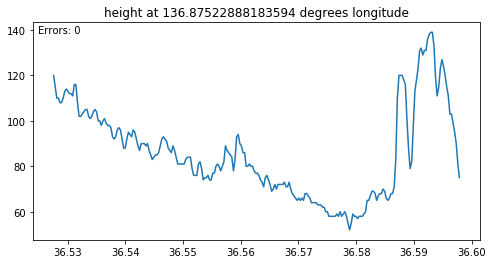

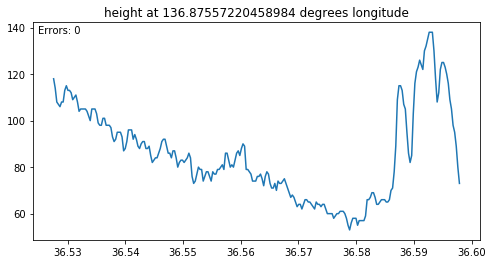

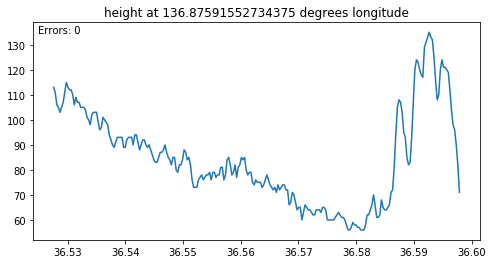

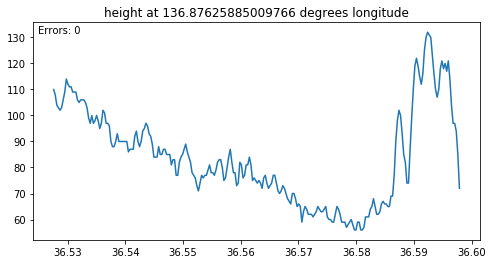

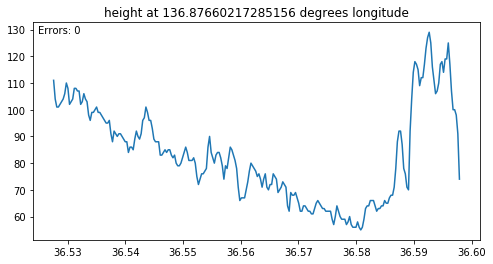

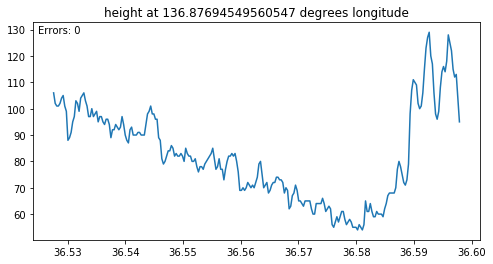

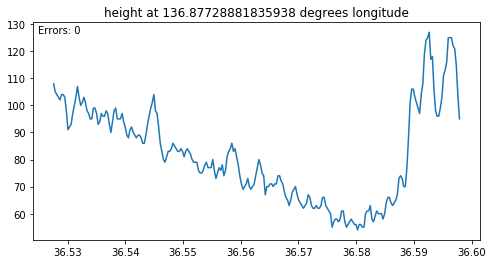

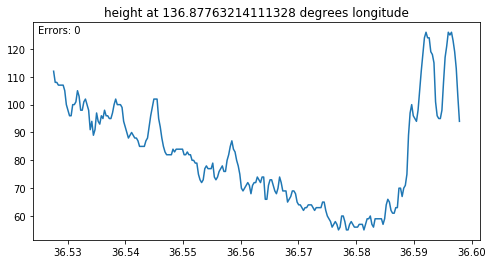

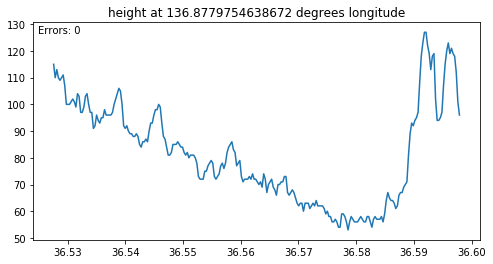

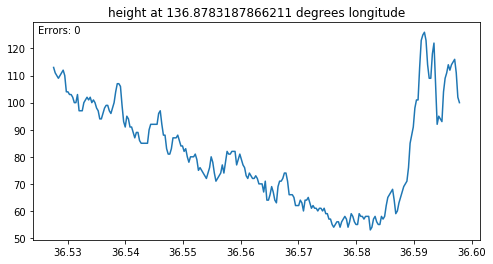

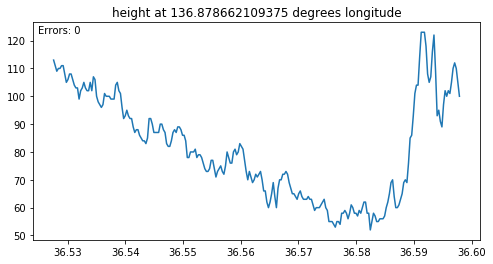

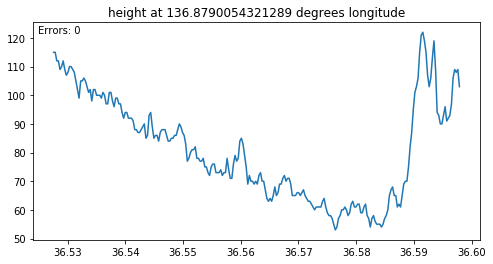

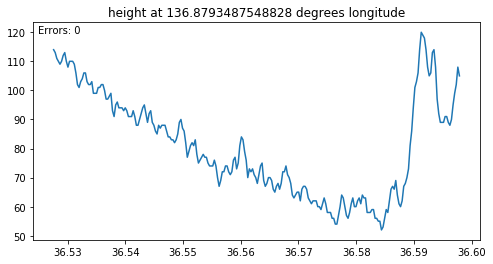

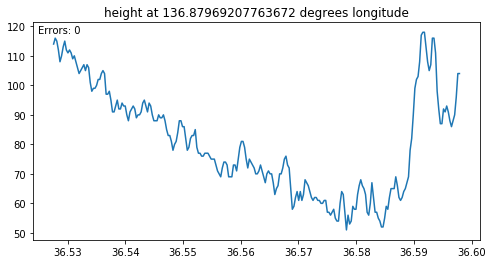

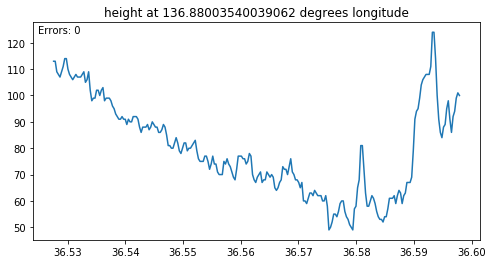

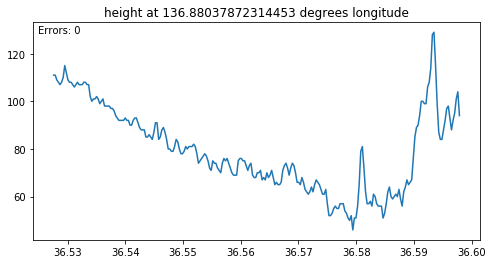

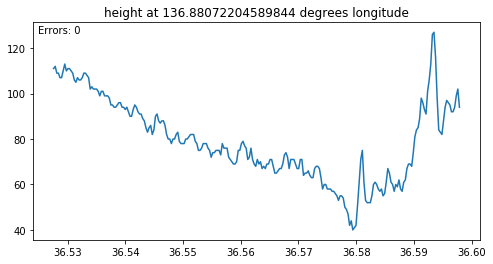

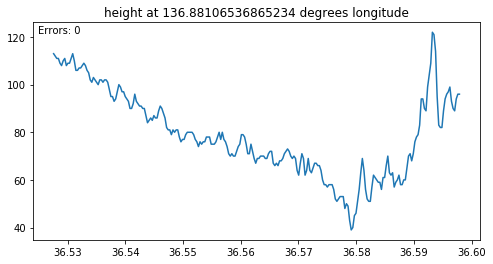

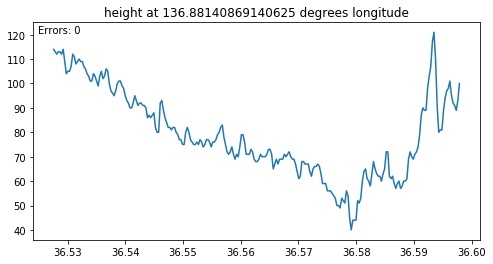

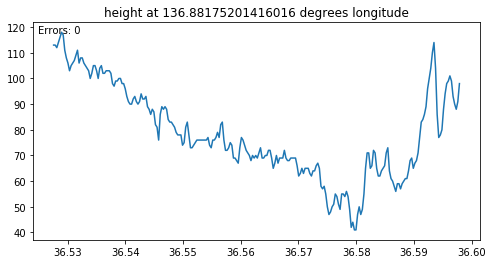

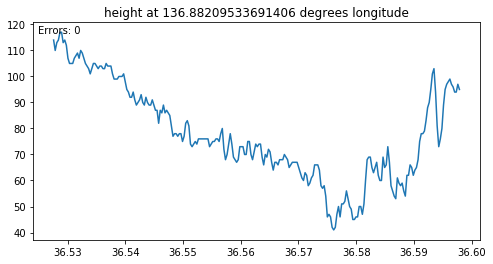

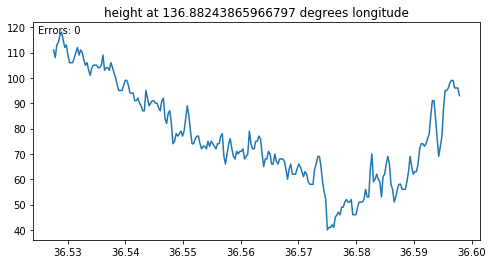

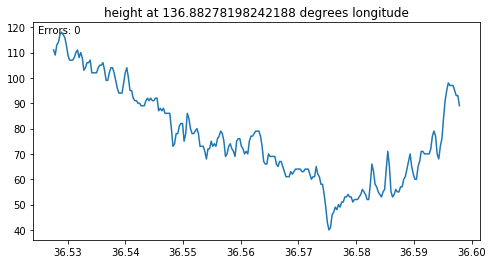

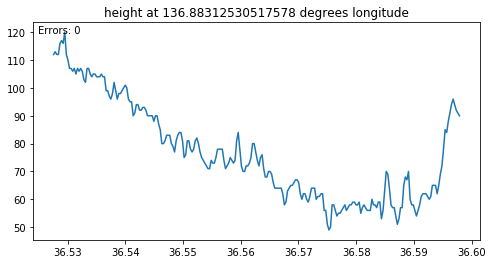

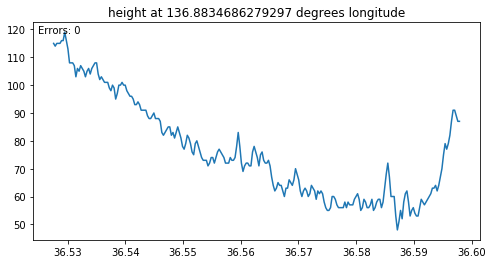

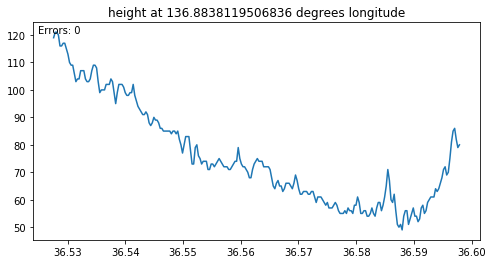

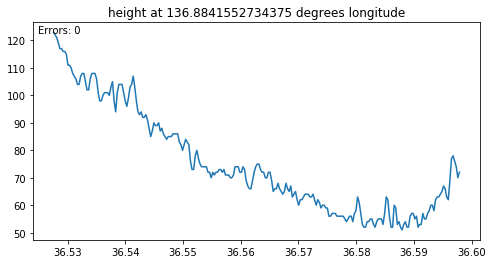

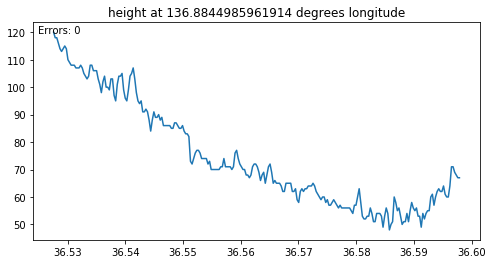

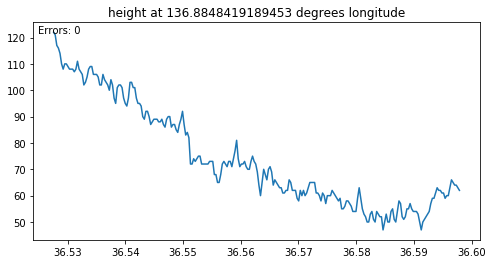

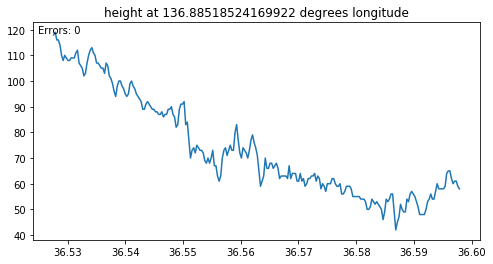

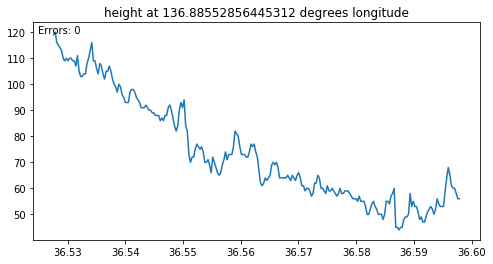

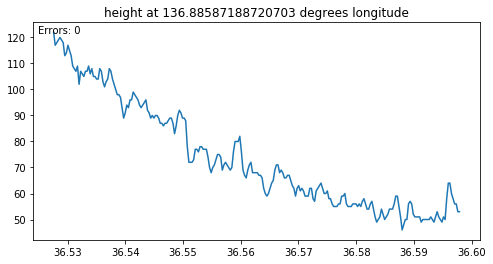

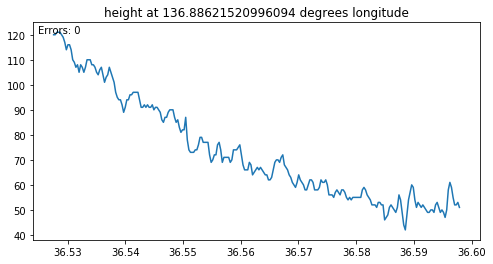

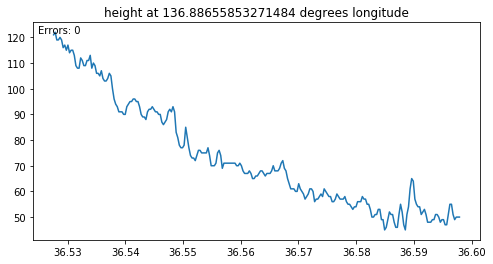

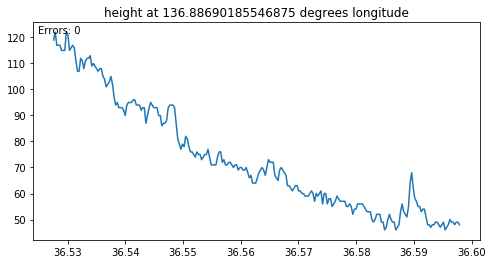

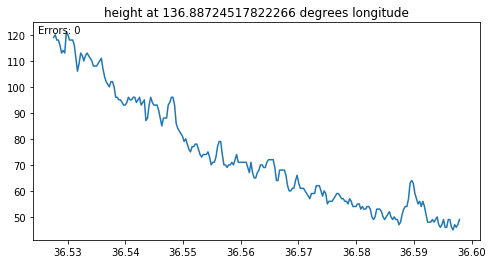

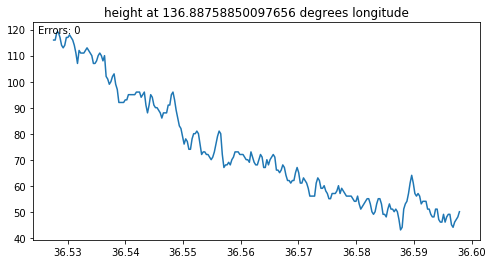

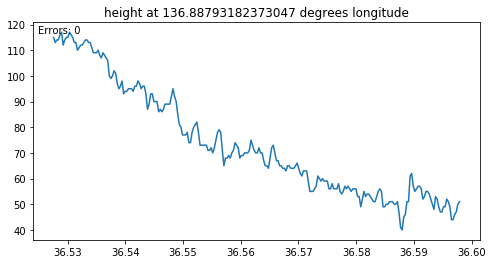

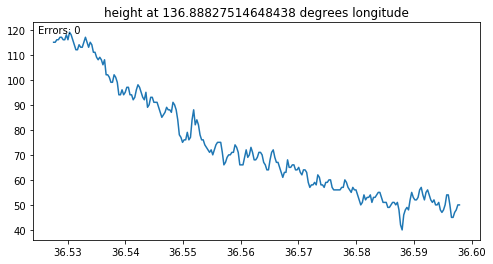

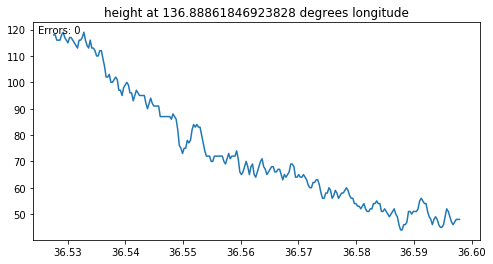

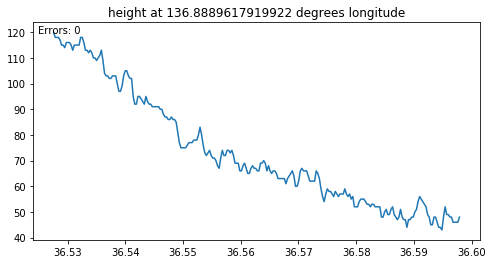

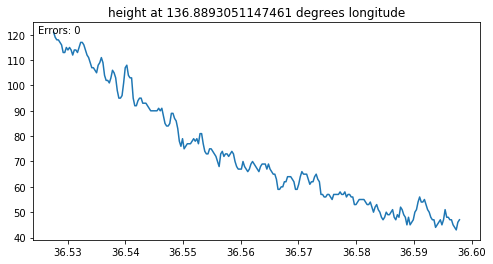

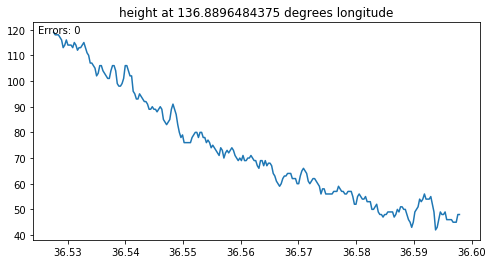

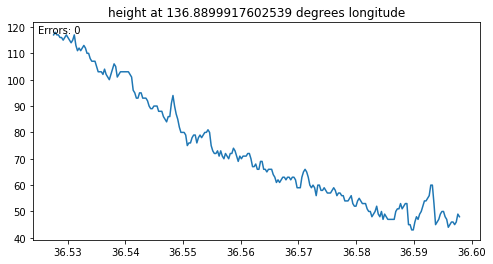

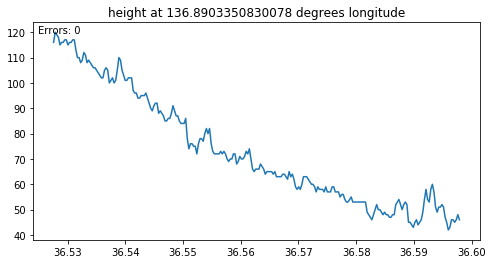

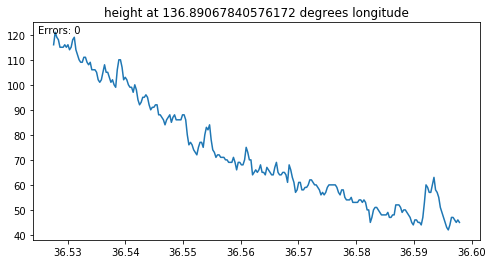

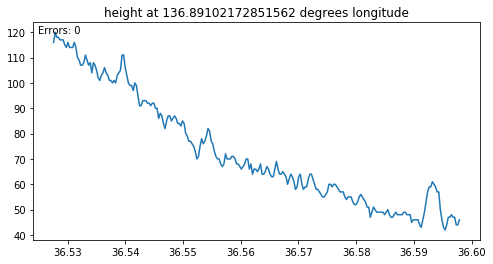

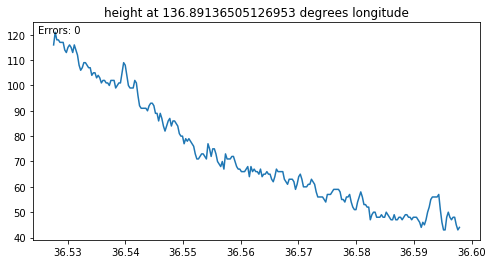

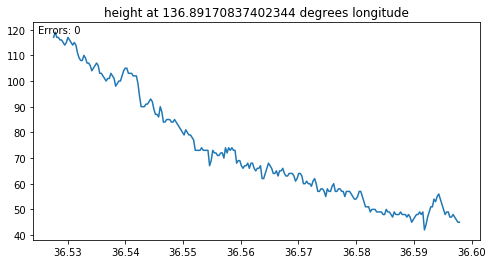

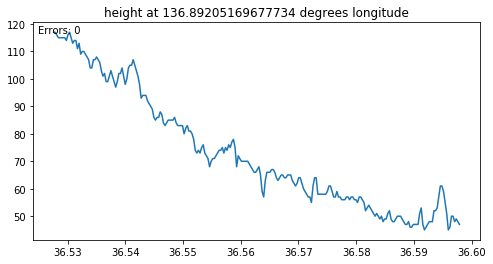

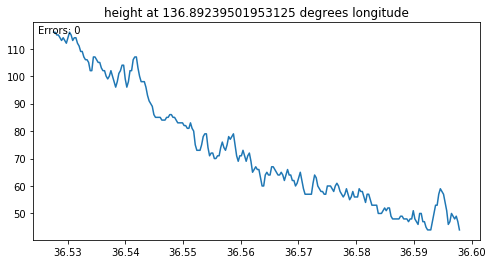

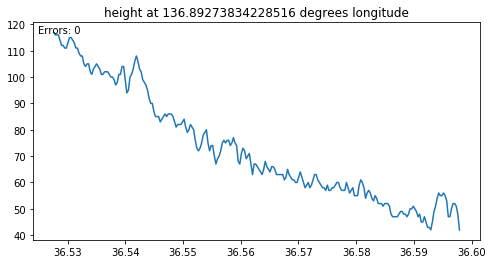

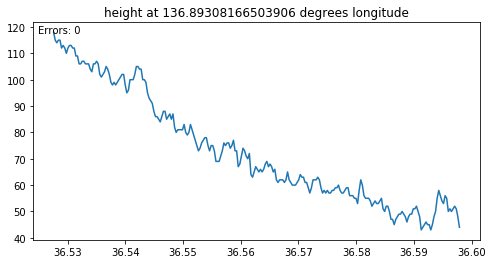

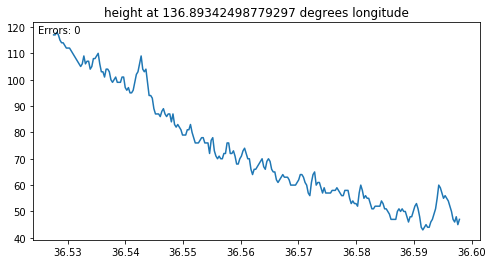

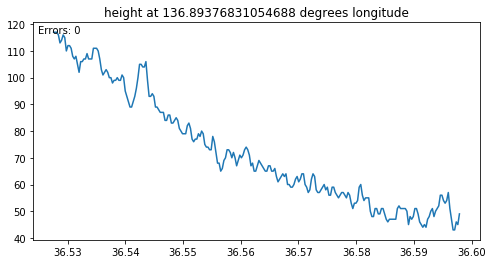

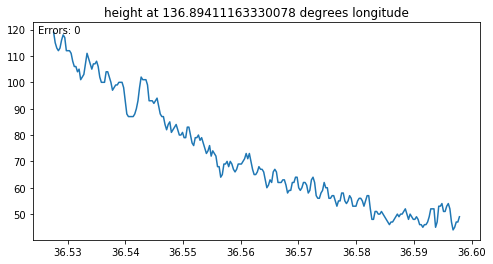

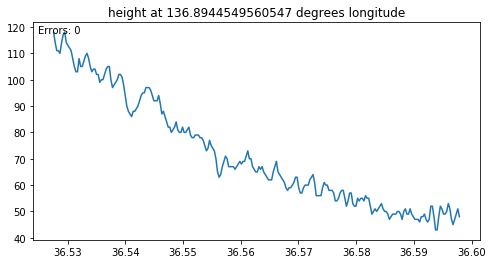

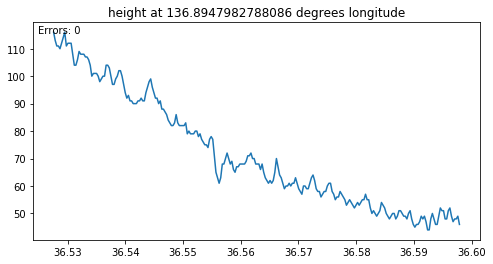

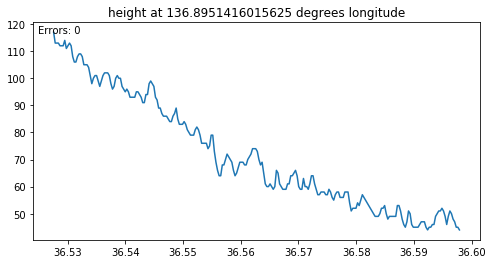

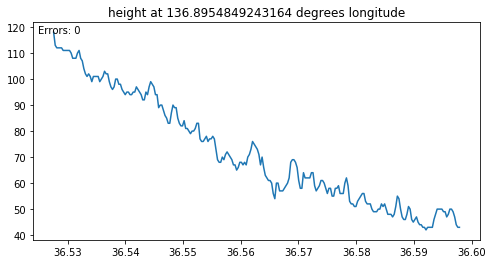

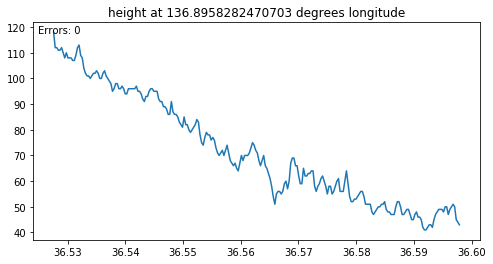

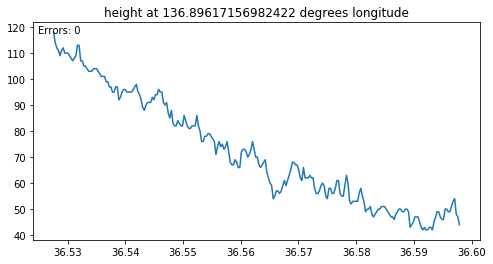

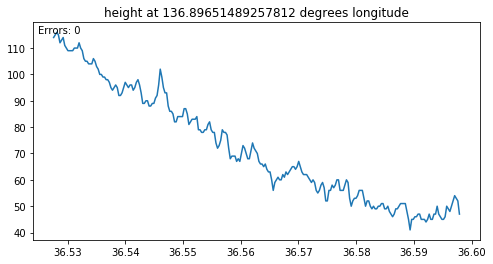

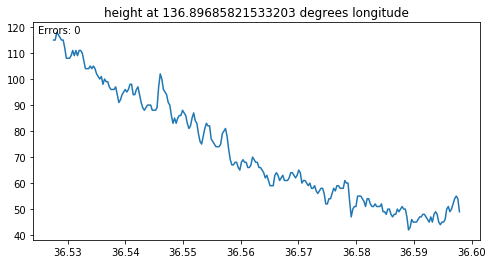

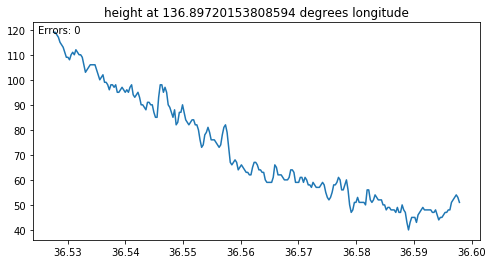

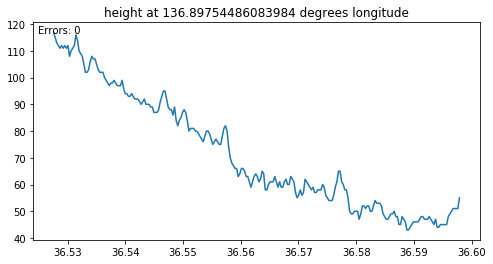

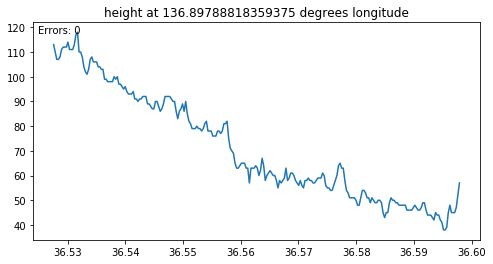

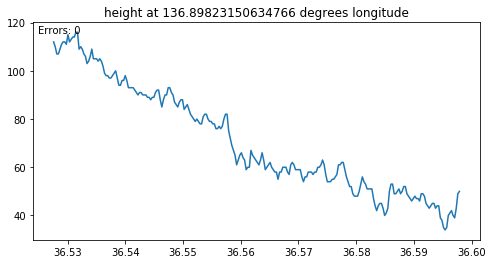

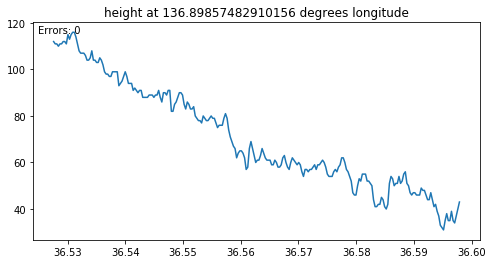

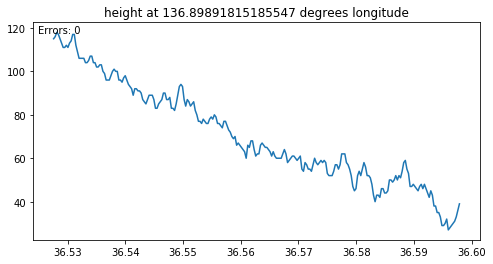

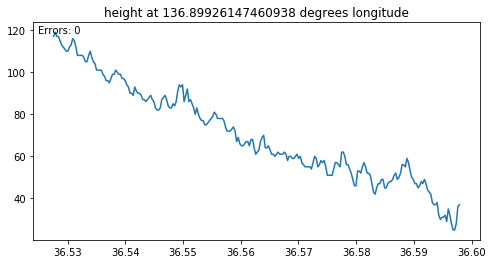

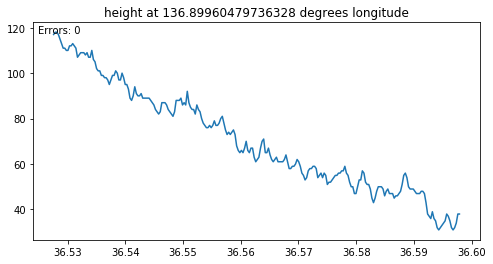

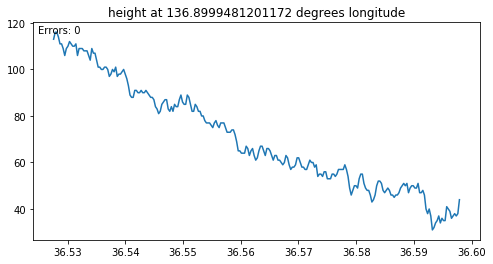

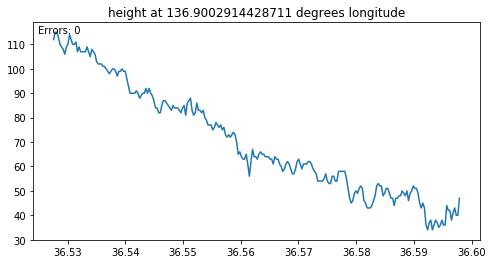

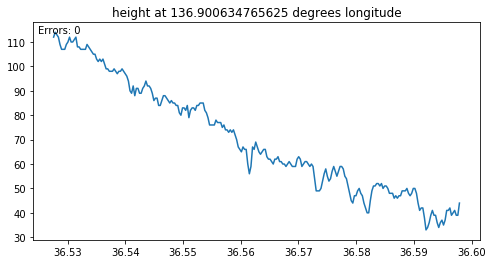

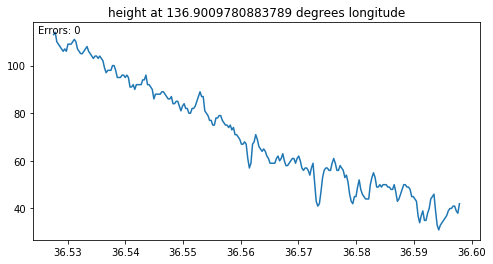

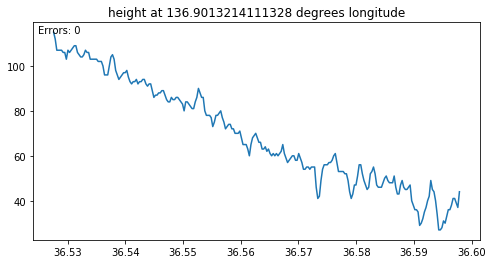

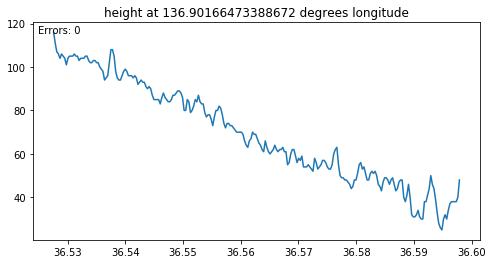

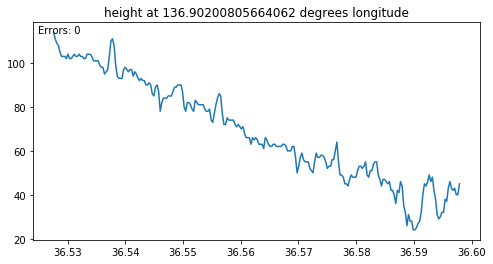

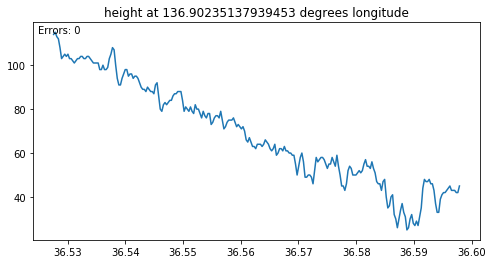

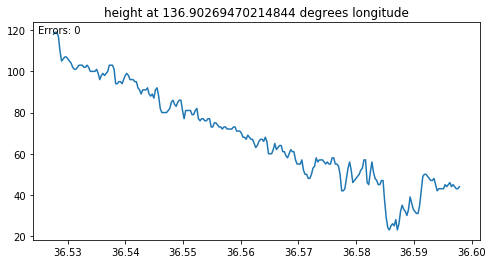

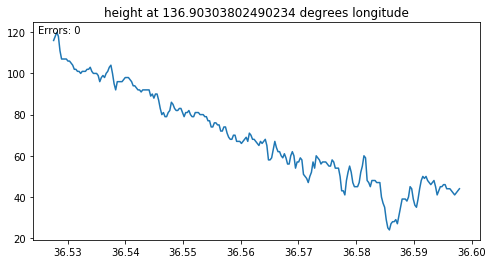

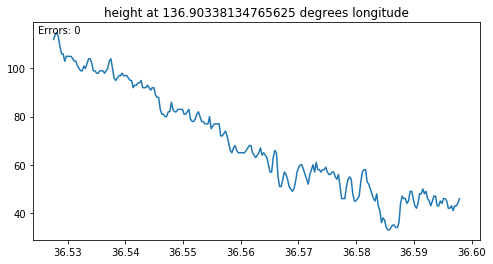

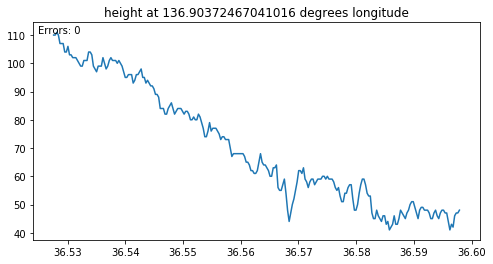

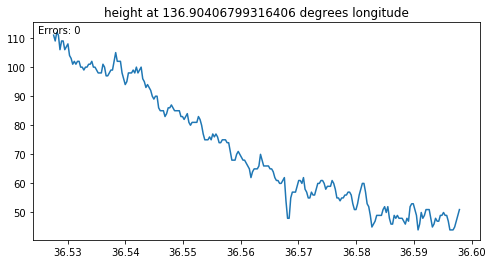

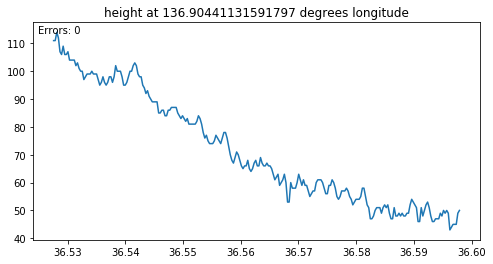

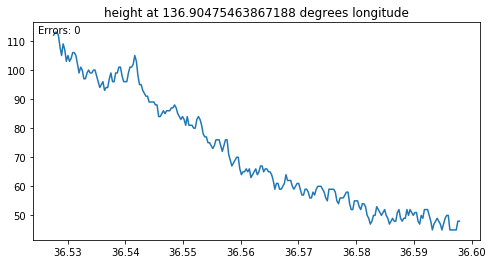

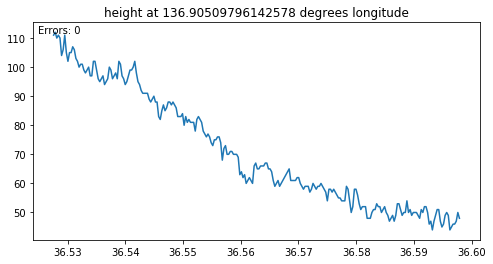

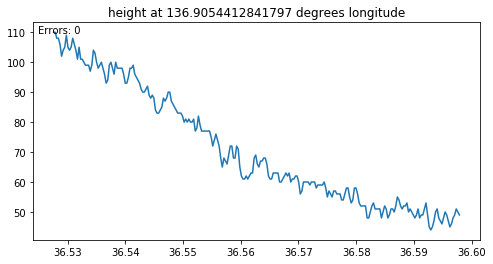

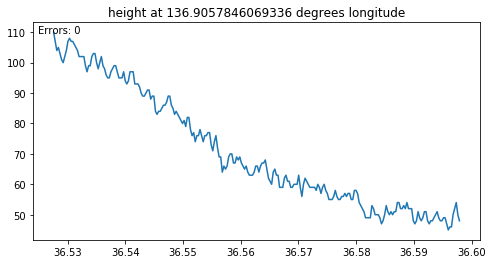

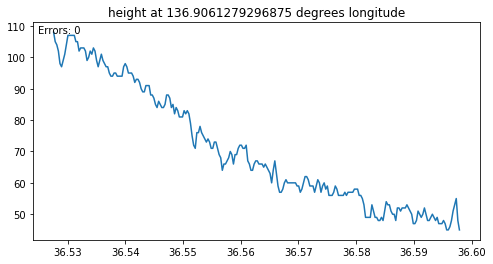

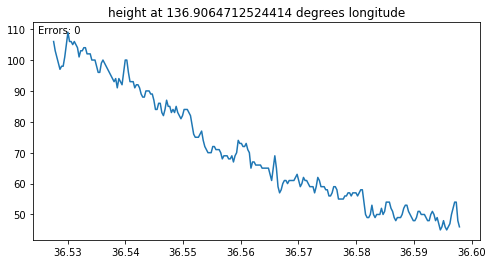

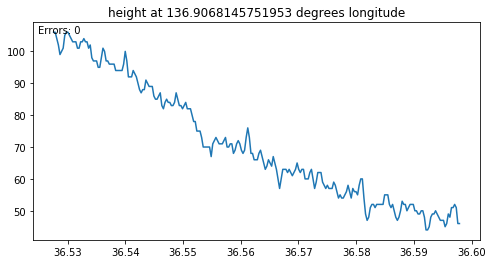

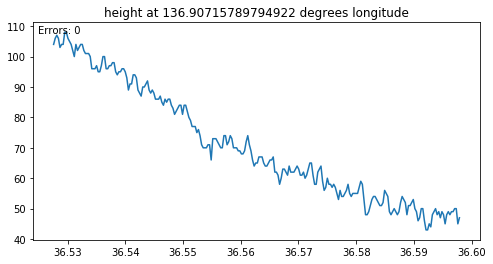

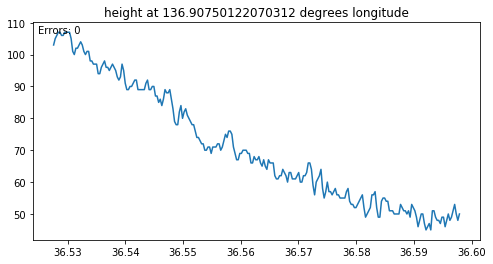

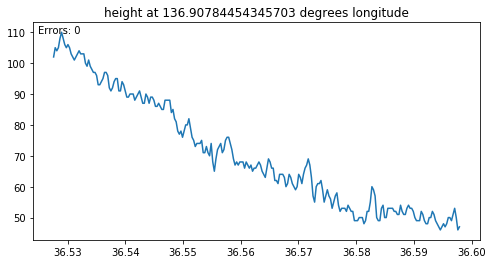

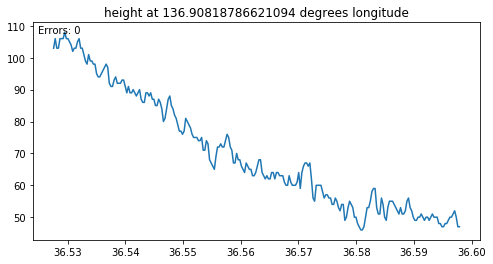

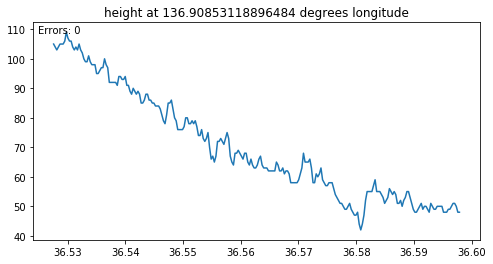

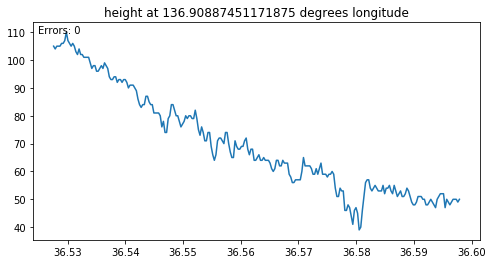

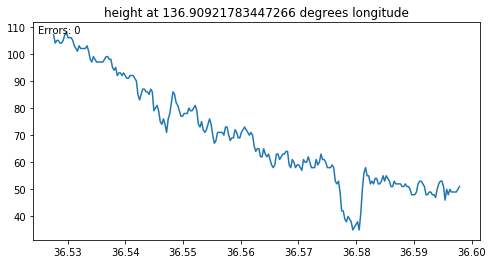

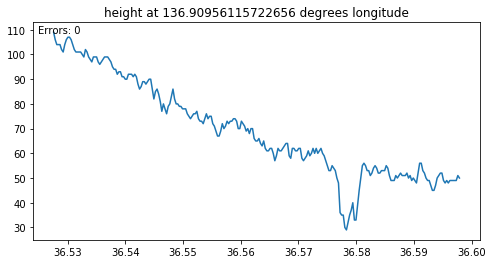

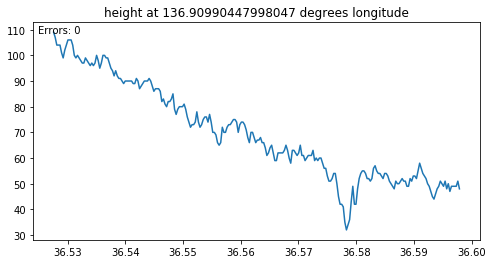

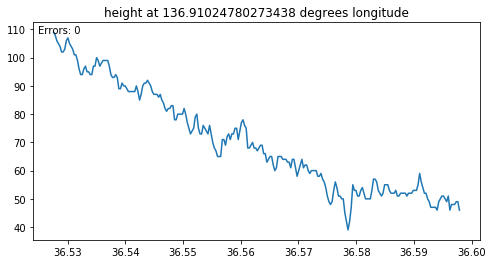

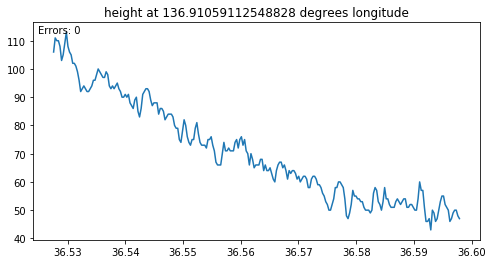

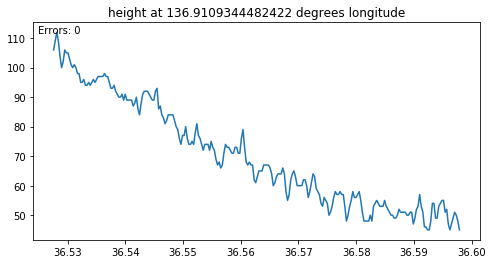

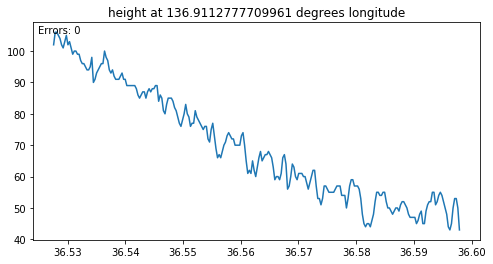

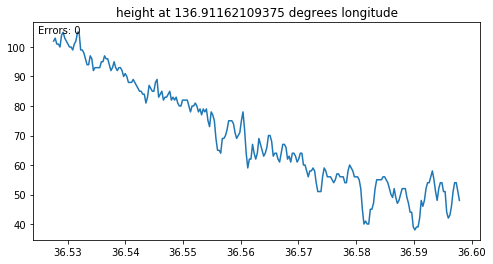

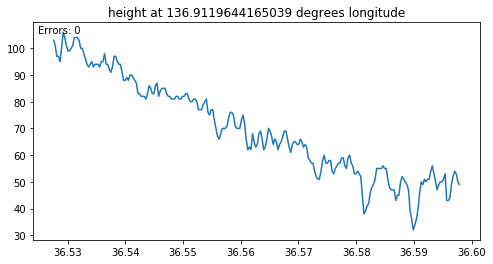

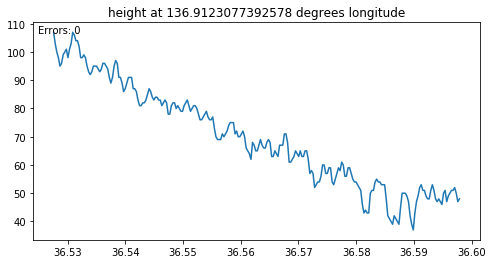

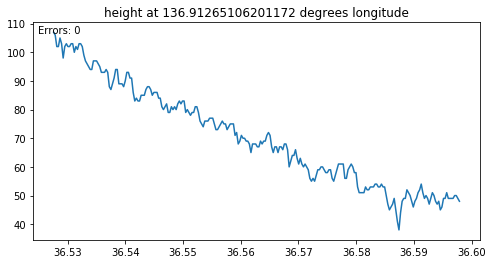

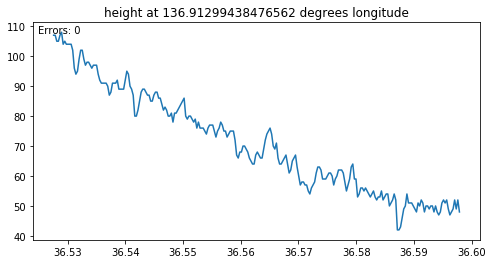

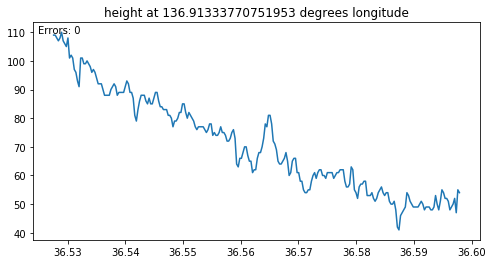

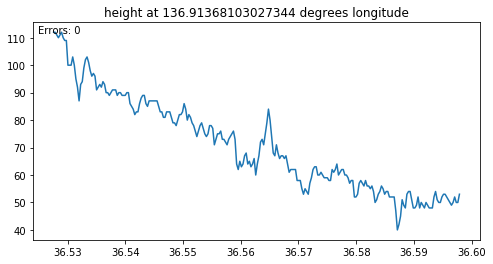

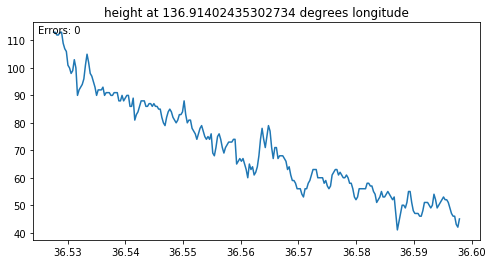

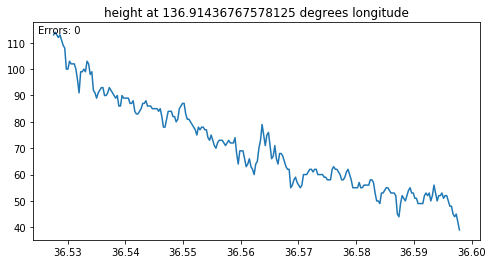

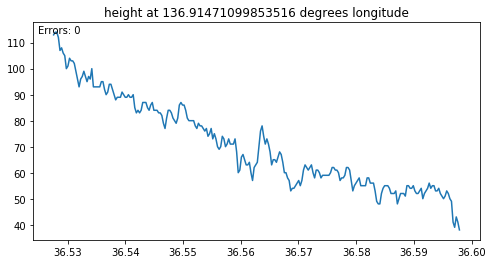

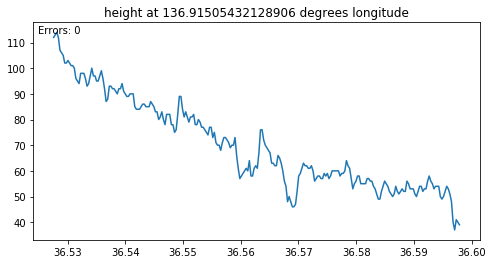

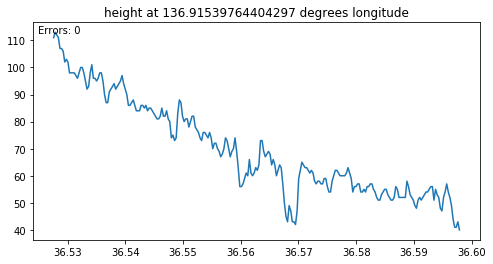

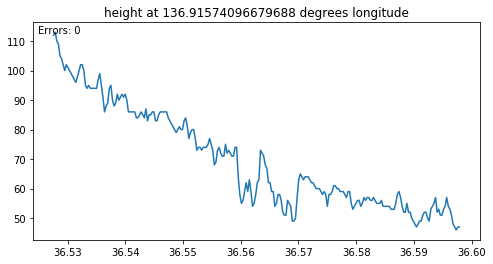

In [ ]:
import os, requests, json
from skimage import io
from io import BytesIO
import math
import matplotlib.pyplot as plt
TOKEN = ''
def get_astergdem2_dsm(zoom, xtile, ytile, option = {}, params = {}):
    """
    ASTER GDEM2 の標高タイルを取得

    Parameters
    ----------
    zoom : str 
        ズーム率 0-12
    xtile : str 
        座標X 
    ytile : number 
        座標Y
    Returns
    -------
    img_array : ndarray
        標高タイル(PNG)
    """

    url = " https://gisapi.tellusxdp.com/astergdem2/dsm/{}/{}/{}.png".format(zoom, xtile, ytile)
    headers = {
        "Authorization": "Bearer " + TOKEN
    }
    r = requests.get(url, headers=headers)

    return io.imread(BytesIO(r.content))

z=12 #0-12
x=3605
y=1600

gdem_img = get_astergdem2_dsm(z, x, y)
io.imshow(gdem_img)

def get_tile_bbox(zoom, topleft_x, topleft_y, size_x=1, size_y=1):
    """
    タイル座標からバウンダリボックスを取得
    https://tools.ietf.org/html/rfc7946#section-5
    """
    def num2deg(xtile, ytile, zoom):
        # https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Python
        n = 2.0 ** zoom
        lon_deg = xtile / n * 360.0 - 180.0
        lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
        lat_deg = math.degrees(lat_rad)
        return (lon_deg, lat_deg)
    
    right_top = num2deg(topleft_x + size_x , topleft_y, zoom)
    left_bottom = num2deg(topleft_x, topleft_y + size_y, zoom)
    return (left_bottom[0], left_bottom[1], right_top[0], right_top[1])

def calc_height_chiriin_style(R, G, B, u=100):
    """
    標高タイルのRGB値から標高を計算する
    """
    hyoko = int(R*256*256 + G * 256 + B)
    if hyoko == 8388608:
        raise ValueError('N/A')
    if hyoko > 8388608:
        hyoko = (hyoko - 16777216)/u
    if hyoko < 8388608:
        hyoko = hyoko/u
    return hyoko

def plot_height(tile, index, direction, z, x, y, xtile_size=1, ytile_size=1, u=1):
    """
    高度のグラフをプロットする

    Parameters
    ----------
    tile : ndarray 
        標高タイル
    bbox : object 
        標高タイルのバウンディングボックス 
    index : number 
        走査するピクセルのインデックス 
    direction : number 
        走査方向(0で上から下、1で左から右)
    zoom : number 
        ズーム率 
    xtile : number 
        座標X 
    ytile : number 
        座標Y
    xtile_size : number 
        X方向のタイル数 
    ytile_size : number  
        Y方向のタイル数
    u : number 
        標高分解能[m]（デフォルト 1.0[m]）
    """
    bbox = get_tile_bbox(z, x, y, xtile_size, ytile_size) 
    width = abs(bbox[2] - bbox[0])
    height = abs(bbox[3] - bbox[1])
    if direction == 0: 
        line = tile[:,index]
        per_deg = -1 * height/tile.shape[0]
        fixed_deg = width/tile.shape[1] * index + bbox[0]
        deg = bbox[3]
        title = 'height at {} degrees longitude'.format(fixed_deg)
    else:
        line = tile[index,:]
        per_deg = width/tile.shape[1]
        fixed_deg = -1 * height/tile.shape[0] * index + bbox[3]
        deg = bbox[0]
        title = 'height at {} degrees latitude'.format(fixed_deg)
        
    heights = []
    heights_err = []
    degrees = []
    FacingSouth=[]
    f = open('./facingSouth_{}_0.txt'.format(index), 'w')
    for k in range(len(line)): #direction==0の場合はdegreesの降順、direction==1の場合は昇順
        R = line[k,0]
        G = line[k,1]
        B = line[k,2]
        if k==0:
            before_height = calc_height_chiriin_style(R, G, B, u) #初回
        try:
            heights.append(calc_height_chiriin_style(R, G, B, u))
        except ValueError as e:
            heights.append(0)
            heights_err.append((i,j))
        degrees.append(deg)
        deg += per_deg
        if ( before_height - calc_height_chiriin_style(R, G, B, u) ) > 5:
            FacingSouth.append(1)
        else:
            FacingSouth.append(0)
        before_height = calc_height_chiriin_style(R, G, B, u) #前回値
        strOutput = "{},{},{},{}".format(k,deg,fixed_deg,FacingSouth[k])
        f.write(strOutput+'\n')
    fig, ax= plt.subplots(figsize=(8, 4)) 
    plt.plot(degrees, heights)
    plt.title(title)
    ax.text(0.01, 0.95, 'Errors: {}'.format(len(heights_err)), transform=ax.transAxes)
    plt.show()
    f.close()
for k in range(256):
    plot_height(gdem_img, k, 0, z, x, y)
